שאלה 1

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
import math
import random
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
input_size = 2
output_size = 1
data = [(1., 1.), (2., 2.), (3., 0.), (4., 2.)]
data = torch.tensor(data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on device "{device}"')

Working on device "cuda"


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size, func):
        super(SimpleNN, self).__init__()
        self.first_linear = nn.Linear(input_size, input_size)
        self.second_linear = nn.Linear(input_size, output_size)
        self.fun = func
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.first_linear(x)
        if self.fun == "relu":
          out = self.relu(out)
        if self.fun == "tanh":
          out = self.tanh(out)
        out = self.second_linear(out)
        return out

    def classify(self, datapoint):
      a = self.forward(datapoint)
      if a > 0:
        return True
      return False

    def correlation(self, data, labels):
        assert len(data) == len(labels)
        assert all(x == 1 or x == -1 for x in labels)
        predicted = [1 if(self.classify(d)) else -1 for d in data]
        return float(np.dot(predicted, labels)) / float(len(data))


In [ ]:
def coin_tosses(number, random_seed=0):

    
    if random_seed != 0:
        random.seed(random_seed)
        np.random.seed(random_seed)

    return [np.random.randint(0, 2) * 2 - 1 for x in range(number)]

In [ ]:

def rademacher_estimate(dataset, hypothesis_generator, num_samples=50000, random_seed=0):


    total = list()

    for ii in range(num_samples):
        if random_seed != 0:
            rademacher = coin_tosses(len(dataset), random_seed + ii)
        else:
            rademacher = coin_tosses(len(dataset))

        total.append(max([h.correlation(dataset, rademacher) for h in list(hypothesis_generator(dataset))]))

    return sum(total) / num_samples

In [ ]:
def init(model):
  nn.init.normal_(model.first_linear.weight, 1, 1)
  nn.init.normal_(model.second_linear.weight, 1, 1)
  nn.init.normal_(model.first_linear.bias, 1, 1)
  nn.init.normal_(model.second_linear.bias, 1, 1)


In [ ]:
models_without = []
for i in range(50):
  i = SimpleNN(input_size, output_size, "without")
  init(i)
  models_without.append(i)

models_relu = []
for i in range(50):
  i = SimpleNN(input_size, output_size, "relu")
  init(i)
  models_relu.append(i)


models_tanh = []
for i in range(50):
  i = SimpleNN(input_size, output_size, "tanh")
  init(i)
  models_tanh.append(i)

In [ ]:
def hypothesis_without_generator(dataset):
  return models_without

def hypothesis_relu_generator(dataset):
  return models_relu

def hypothesis_tanh_generator(dataset):
  return models_tanh

In [ ]:
print(f'NN without activation classifier {rademacher_estimate(data, hypothesis_without_generator)}')
print(f'NN with relu classifier  {rademacher_estimate(data, hypothesis_relu_generator)}')
print(f'NN with tanh classifier {rademacher_estimate(data, hypothesis_tanh_generator)}')


NN without activation classifier 0.65445
NN with relu classifier  0.62625
NN with tanh classifier 0.65804


שאלה 3

In [ ]:
std = 0.1
weights = torch.rand(100)
norm_weights = weights / torch.linalg.norm(weights)
testX = torch.normal(0, 1, size = (10000, 100))
epsilon = torch.normal(0, std, size = (1, 100))
min_train_size = 20
max_train_size = 200
RMSE = []

In [ ]:
def new_label(true_weights, feature_matrix):
    error = torch.squeeze(torch.normal(0, std, size = (feature_matrix.size()[0],1)))
    return feature_matrix @ true_weights + error

def calculate_RMSE(feature_matrix, weight_estimate, true_weights):
    return torch.sqrt(torch.mean(torch.square(torch.subtract(torch.matmul(feature_matrix, weight_estimate), new_label(true_weights, feature_matrix)))))

In [ ]:
for num in range(min_train_size, max_train_size):
    train_X = torch.normal(0 , 1, size = (num, 100))
    train_Y = new_label(norm_weights, train_X)
    approximate_weight = torch.linalg.lstsq(train_X, train_Y).solution
    RMSE.append(calculate_RMSE(testX, approximate_weight, norm_weights))

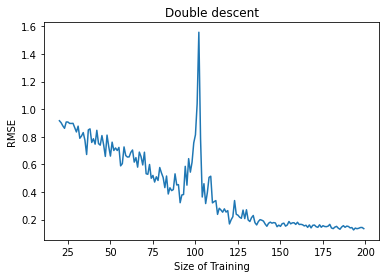

In [ ]:
plt.plot(range(min_train_size, max_train_size), RMSE)
plt.title("Double descent")
plt.ylabel("RMSE")
plt.xlabel("Size of Training")
plt.show()